In [8]:
import gymnasium as gym
import time as time
import numpy as np

import sys

sys.path.append("..")

import src.diffusion.black_scholes as black_scholes
import src.dqn.one_dim_bermudan as bermudan
import src.dqn.agent as agent
import pandas as pd
import torch

import seaborn as sns
import matplotlib.pyplot as plt

In [9]:
strike = 1
r = 0.06
vol = 0.2
spot = 36 / 40
maturity = 1
n_simulation = 50
epsilon = 0.01
epsilon_decay = 0.0008
epsilon_max = 0.99
learning_rate = 0.009
d = 1
batch_size = 10000
replay_memory_init = 30000
replay_memory_capacity = 100000
N_update = 100


myagent = agent.Agent(
    epsilon,
    epsilon_decay,
    epsilon_max,
    replay_memory_init,
    replay_memory_capacity,
    N_update,
    learning_rate,
    batch_size,
    d,
)

process = black_scholes.BlackScholes(spot, r, vol)
put_option_payoff = lambda x: max(strike - x, 0)

option = bermudan.OneDimensionalBermudan(
    process, put_option_payoff, maturity, r, myagent
)

In [10]:
n_episodes = 15000
rewars, rewards_batch, losses, pos, epsilon, exploit_explore, myagent = option.train(
    n_simulation, n_episodes, disable=False, seed=2024
)

100%|██████████| 15000/15000 [41:24<00:00,  6.04it/s]  


In [11]:
count = 0
while losses[count] == 0:
    count += 1
start_training = count
print(f"started training at {start_training} epoch")

started training at 12714 epoch


C:\Users\amaury.manzione\AppData\Local\Temp\ipykernel_10152\1584135904.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


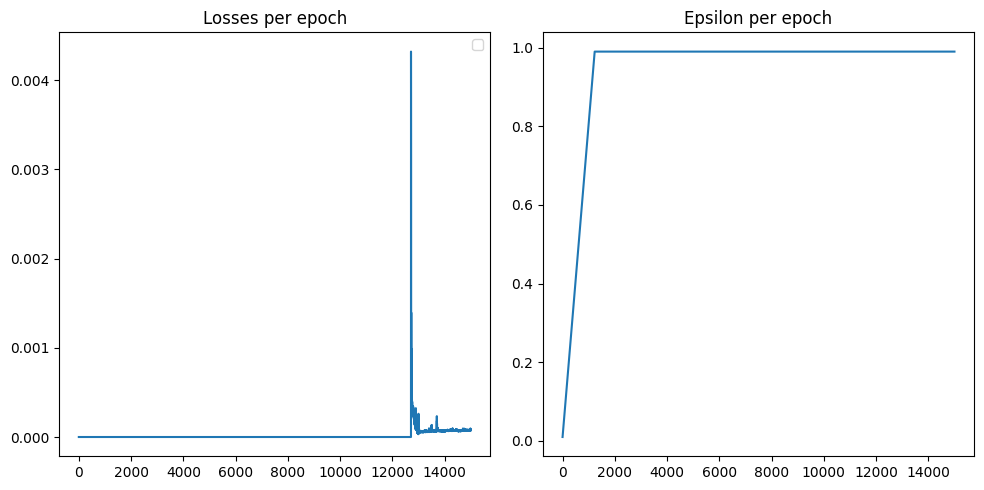

In [12]:
# Use the inline backend to display plots inline within the notebook
%matplotlib inline

# Create a figure
plt.figure(figsize=(10, 5))

# First subplot
plt.subplot(1, 2, 1)
plt.plot(losses)
plt.title('Losses per epoch')
# plt.axvline(x=start_training, color='r', linestyle='--', linewidth=1, label='start of training')
plt.legend()

# Second subplot
plt.subplot(1, 2, 2)
plt.plot(epsilon)
plt.title('Epsilon per epoch')

# Show the plots
plt.tight_layout()
plt.show()

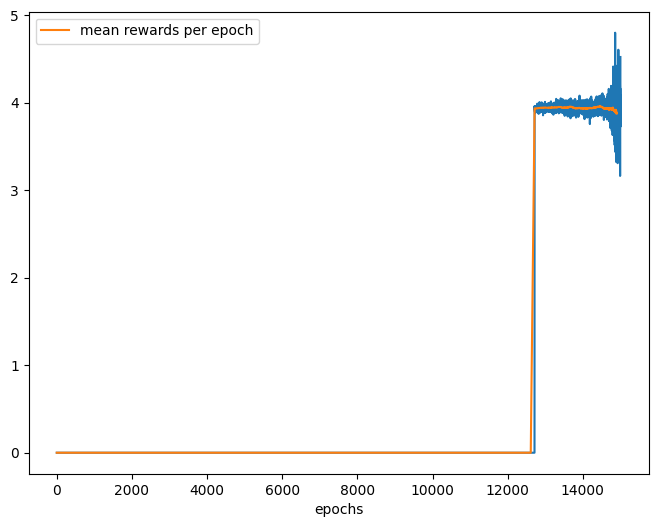

In [13]:
n = rewards_batch.shape[0]
history_mean = [torch.mean(rewards_batch[i : i + 100]) * 40 for i in range(1, n - 100)]
plt.figure(figsize=(8, 6))
plt.plot(rewards_batch * 40)
plt.plot(history_mean, label="mean rewards per epoch")
plt.xlabel("epochs")
plt.legend()

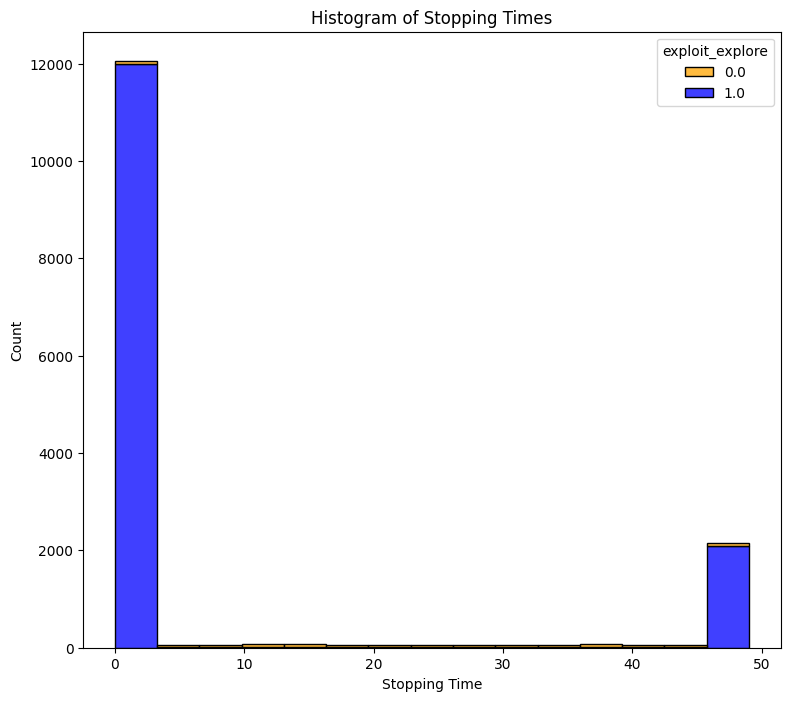

In [14]:
plt.figure(figsize=(9, 8))

df = pd.DataFrame({"pos": pos, "exploit_explore": exploit_explore})

# Create the histplot with different colors for "exploit" and "explore"
sns.histplot(
    data=df,
    x="pos",
    hue="exploit_explore",
    multiple="stack",
    palette={1: "blue", 0: "orange"},
)

# Add titles and labels
plt.title("Histogram of Stopping Times")
plt.xlabel("Stopping Time")
plt.ylabel("Count")

# Show the plot
plt.show()

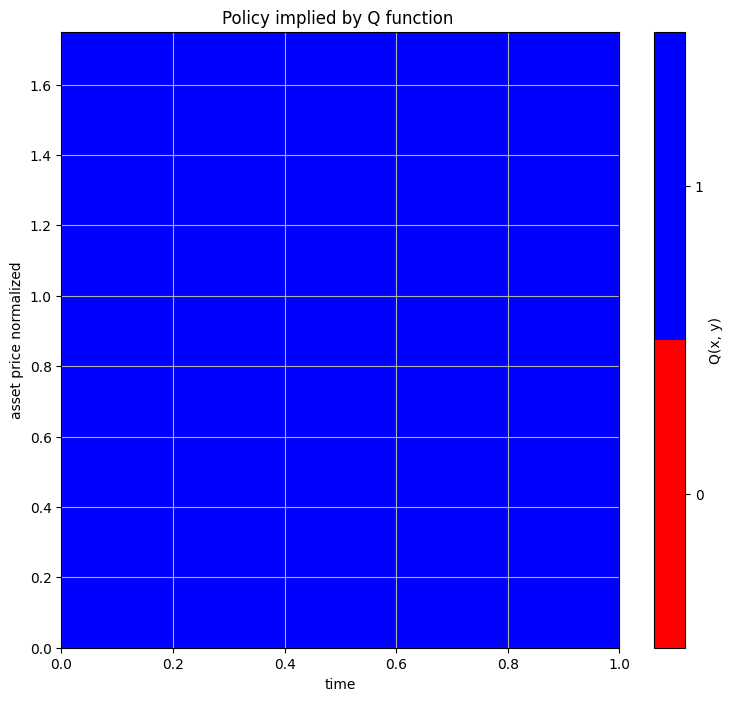

In [15]:
# Define the grid
y = np.linspace(0, 70 / 40, 100)
x = np.linspace(0, 1, 100)
X, Y = np.meshgrid(x, y)


def f(x, y):
    input_to_tensor = torch.tensor(np.array([y, x])).unsqueeze(0)
    policy = myagent.get_policy(input_to_tensor)
    return policy


# Evaluate the function on the grid
Z = np.zeros_like(X)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        Z[i, j] = f(X[i, j], Y[i, j])

# Plot the results with specified colors
plt.figure(figsize=(9, 8))
plt.contourf(X, Y, Z, levels=[-0.5, 0.5, 1.5], colors=["red", "blue"])
plt.colorbar(ticks=[0, 1], label="Q(x, y)")
plt.title("Policy implied by Q function ")
plt.xlabel("time")
plt.ylabel("asset price normalized")
plt.grid()
plt.show()

In [16]:
option.get_price(myagent,50,10000)

100%|██████████| 10000/10000 [00:57<00:00, 174.04it/s]


0.0965836572775784

In [17]:
0.0965836572775784*40

3.8633462911031358